# CrowdTruth for Sparse Multiple Choice Tasks: Person Annotation in Video

In this tutorial, we will apply CrowdTruth metrics to a **multiple choice** crowdsourcing task for **Person Annotation** from **video fragments**. The workers were asked to watch a video of about 3-5 seconds and then pick from a multiple choice list which are the tags that are relevant for the people that appear in the video fragment. The task was executed on [FigureEight](https://www.figure-eight.com/).

To replicate this experiment, the code used to design and implement this crowdsourcing annotation template is available here: [template](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/templates/People-Video-Sparse-Multiple-Choice/template.html), [css](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/templates/People-Video-Sparse-Multiple-Choice/template.css), [javascript](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/templates/People-Video-Sparse-Multiple-Choice/template.js). 

This is a screenshot of the task as it appeared to workers:

![Task Template](img/person-video-sparse-multiple-choice.png)

A sample dataset for this task is available in [this file](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/data/person-video-sparse-multiple-choice.csv), containing raw output from the crowd on FigureEight. Download the file and place it in a folder named `data` that has the same root as this notebook. Now you can check your data:

In [1]:
import pandas as pd

test_data = pd.read_csv("data/person-video-sparse-multiple-choice.csv")
test_data.head()

,_unit_id,_created_at,_id,_started_at,_tainted,_channel,_trust,_worker_id,_country,_region,...,imagelocation,imagetags,keyframeid_gold,selected_answer_gold,selectedtags_desc_gold,selectedtags_subs_gold,selectedtags_tags_gold,subtitles,subtitletags,videolocation
0,1856543729,8/29/2018 08:54:08,4013193103,8/29/2018 08:53:31,False,prodege,1,39740855,CAN,ON,...,https://joran.org/ct/entity.admin.unit.2649/85...,industry__c0_###_grinder__c1_###_production__c...,NaN,NaN,NaN,NaN,NaN,Italian astronaut samantha cristoforetti uploa...,Italian__0_###_astronaut__1_###_samantha__2_##...,https://joran.org/ct/entity.admin.unit.2649/85...
1,1856543729,8/29/2018 10:03:13,4013287341,8/29/2018 10:02:57,False,prodege,1,15555970,GBR,C9,...,https://joran.org/ct/entity.admin.unit.2649/85...,industry__c0_###_grinder__c1_###_production__c...,NaN,NaN,NaN,NaN,NaN,Italian astronaut samantha cristoforetti uploa...,Italian__0_###_astronaut__1_###_samantha__2_##...,https://joran.org/ct/entity.admin.unit.2649/85...
2,1856543729,8/29/2018 10:56:22,4013380117,8/29/2018 10:55:43,False,clixsense,1,6576528,CAN,SK,...,https://joran.org/ct/entity.admin.unit.2649/85...,industry__c0_###_grinder__c1_###_production__c...,NaN,NaN,NaN,NaN,NaN,Italian astronaut samantha cristoforetti uploa...,Italian__0_###_astronaut__1_###_samantha__2_##...,https://joran.org/ct/entity.admin.unit.2649/85...
3,1856543729,8/29/2018 12:01:25,4013479228,8/29/2018 12:01:06,False,instagc,1,15176395,USA,IN,...,https://joran.org/ct/entity.admin.unit.2649/85...,industry__c0_###_grinder__c1_###_production__c...,NaN,NaN,NaN,NaN,NaN,Italian astronaut samantha cristoforetti uploa...,Italian__0_###_astronaut__1_###_samantha__2_##...,https://joran.org/ct/entity.admin.unit.2649/85...
4,1856543729,8/29/2018 12:15:04,4013505367,8/29/2018 12:10:54,False,prodege,1,40988797,CAN,NS,...,https://joran.org/ct/entity.admin.unit.2649/85...,industry__c0_###_grinder__c1_###_production__c...,NaN,NaN,NaN,NaN,NaN,Italian astronaut samantha cristoforetti uploa...,Italian__0_###_astronaut__1_###_samantha__2_##...,https://joran.org/ct/entity.admin.unit.2649/85...


## Declaring a pre-processing configuration

The pre-processing configuration defines how to interpret the raw crowdsourcing input. To do this, we need to define a configuration class. First, we import the default CrowdTruth configuration class:

In [2]:
import crowdtruth
from crowdtruth.configuration import DefaultConfig

Our test class inherits the default configuration `DefaultConfig`, while also declaring some additional attributes that are specific to the Person Type/Role Annotation in Video task:

* **`inputColumns`:** list of input columns from the .csv file with the input data
* **`outputColumns`:** list of output columns from the .csv file with the answers from the workers
* **`annotation_separator`:** string that separates between the crowd annotations in `outputColumns`
* **`open_ended_task`:** boolean variable defining whether the task is open-ended (i.e. the possible crowd annotations are not known beforehand, like in the case of free text input); in the task that we are processing, workers pick the answers from a pre-defined list, therefore the task is not open ended, and this variable is set to `False`
* **`annotation_vector`:** list of possible crowd answers, mandatory to declare when `open_ended_task` is `False`; for our task, this is the list of relations
* **`processJudgments`:** method that defines processing of the raw crowd data; for this task, we process the crowd answers to correspond to the values in `annotation_vector`

The complete configuration class is declared below:

In [3]:
class TestConfig(DefaultConfig):
    inputColumns = ["videolocation", "subtitles", "imagetags", "subtitletags"]
    outputColumns = ["selected_answer"]
    
    # processing of a closed task
    open_ended_task = True
    annotation_vector = []
    
    def processJudgments(self, judgments):
        # pre-process output to match the values in annotation_vector
        for col in self.outputColumns:
            # transform to lowercase
            judgments[col] = judgments[col].apply(lambda x: str(x).lower())
            # remove square brackets from annotations
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('[',''))
            judgments[col] = judgments[col].apply(lambda x: str(x).replace(']',''))
            # remove the quotes around the annotations
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('"',''))
        return judgments

## Pre-processing the input data

After declaring the configuration of our input file, we are ready to pre-process the crowd data:

In [4]:
data, config = crowdtruth.load(
    file = "data/person-video-sparse-multiple-choice.csv",
    config = TestConfig()
)

data['judgments'].head()

,output.selected_answer,output.selected_answer.count,output.selected_answer.unique,submitted,started,worker,unit,duration,job
judgment,,,,,,,,,
4013193103,"{u'0_###_italian': 1, u'1_###_astronaut': 1}",2,2,2018-08-29 08:54:08,2018-08-29 08:53:31,39740855,1856543729,37,data/person-video-sparse-multiple-choice
4013287341,"{u'0_###_italian': 1, u'1_###_astronaut': 1, u...",8,8,2018-08-29 10:03:13,2018-08-29 10:02:57,15555970,1856543729,16,data/person-video-sparse-multiple-choice
4013380117,"{u'0_###_italian': 1, u'1_###_astronaut': 1, u...",9,9,2018-08-29 10:56:22,2018-08-29 10:55:43,6576528,1856543729,39,data/person-video-sparse-multiple-choice
4013479228,"{u'0_###_italian': 1, u'1_###_astronaut': 1, u...",6,6,2018-08-29 12:01:25,2018-08-29 12:01:06,15176395,1856543729,19,data/person-video-sparse-multiple-choice
4013505367,"{u'1_###_astronaut': 1, u'2_###_samantha': 1}",2,2,2018-08-29 12:15:04,2018-08-29 12:10:54,40988797,1856543729,250,data/person-video-sparse-multiple-choice


## Computing the CrowdTruth metrics

The pre-processed data can then be used to calculate the CrowdTruth metrics:

In [5]:
results = crowdtruth.run(data, config)

`results` is a dict object that contains the quality metrics for the video fragments, annotations and crowd workers.

The **video fragment metrics** are stored in `results["units"]`:

In [6]:
results["units"].head()

,duration,input.imagetags,input.subtitles,input.subtitletags,input.videolocation,job,output.selected_answer,output.selected_answer.annotations,output.selected_answer.unique_annotations,worker,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial
unit,,,,,,,,,,,,,,
1856543729,41.150000,industry__c0_###_grinder__c1_###_production__c...,Italian astronaut samantha cristoforetti uploa...,Italian__0_###_astronaut__1_###_samantha__2_##...,https://joran.org/ct/entity.admin.unit.2649/85...,data/person-video-sparse-multiple-choice,"{u'c3_###_technology': 6, u'i2_###_technology'...",86,13,20,0.547516,"{u'c3_###_technology': 0.404021944001, u'i2_##...",0.523591,"{u'c3_###_technology': 0.3, u'i2_###_technolog..."
1856543730,28.736842,man__c0_###_soccer__c1_###_portrait__c2_###_pe...,this phenomena is it's massive the,phenomena__0_###_massive__1_###_,https://joran.org/ct/entity.admin.unit.2649/85...,data/person-video-sparse-multiple-choice,"{u'other_###_other': 1, u'i3_###_person': 13, ...",82,10,19,0.701245,"{u'other_###_other': 0.0287128827101, u'i3_###...",0.644335,"{u'other_###_other': 0.0526315789474, u'i3_###..."
1856543731,31.052632,people__c0_###_man__c1_###_adult__c2_###_portr...,around could the lights be coming from,lights__0_###_coming__1_###_,https://joran.org/ct/entity.admin.unit.2649/85...,data/person-video-sparse-multiple-choice,"{u'i2_###_adult': 8, u'i3_###_person': 10, u'c...",88,9,19,0.665422,"{u'i2_###_adult': 0.522170729595, u'i3_###_per...",0.599217,"{u'i2_###_adult': 0.421052631579, u'i3_###_per..."
1856543732,67.315789,water__c0_###_no person__c1_###_ocean__c2_###_...,when investigators map the coordinates onto lo...,investigators__0_###_map__1_###_coordinates__2...,https://joran.org/ct/entity.admin.unit.2649/85...,data/person-video-sparse-multiple-choice,"{u'c4_###_sea': 6, u'none_###_none of the abov...",106,20,19,0.322189,"{u'c4_###_sea': 0.434702945886, u'none_###_non...",0.259780,"{u'c4_###_sea': 0.315789473684, u'none_###_non..."
1856543733,24.500000,sky__c0_###_no person__c1_###_power__c2_###_el...,the bright lights are part of a,bright lights__0_###_,https://joran.org/ct/entity.admin.unit.2649/85...,data/person-video-sparse-multiple-choice,"{u'c4_###_energy': 4, u'none_###_none of the a...",71,13,20,0.374600,"{u'c4_###_energy': 0.21549864663, u'none_###_n...",0.307464,"{u'c4_###_energy': 0.2, u'none_###_none of the..."


The `uqs` column in `results["units"]` contains the **video fragment quality scores**, capturing the overall workers agreement over each video fragment. Here we plot its histogram:

Text(0,0.5,u'Video Fragment')

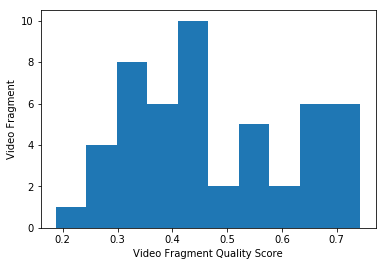

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(results["units"]["uqs"])
plt.xlabel("Video Fragment Quality Score")
plt.ylabel("Video Fragment")

The `unit_annotation_score` column in `results["units"]` contains the **video fragment-annotation scores**, capturing the likelihood that an annotation is expressed in a video fragment. For each video fragment, we store a dictionary mapping each annotation to its video fragment-relation score.

In [8]:
results["units"]["unit_annotation_score"].head()

unit
1856543729    {u'c3_###_technology': 0.404021944001, u'i2_##...
1856543730    {u'other_###_other': 0.0287128827101, u'i3_###...
1856543731    {u'i2_###_adult': 0.522170729595, u'i3_###_per...
1856543732    {u'c4_###_sea': 0.434702945886, u'none_###_non...
1856543733    {u'c4_###_energy': 0.21549864663, u'none_###_n...
Name: unit_annotation_score, dtype: object

The **worker metrics** are stored in `results["workers"]`:

In [9]:
results["workers"].head()

,duration,job,judgment,unit,wqs,wwa,wsa,wqs_initial,wwa_initial,wsa_initial
worker,,,,,,,,,,
1855113,216.16,1,25,25,0.265722,0.495822,0.535922,0.246434,0.424653,0.580318
3587109,13.80,1,10,10,0.270689,0.479933,0.564013,0.233137,0.382904,0.608867
4316379,22.05,1,40,40,0.082394,0.310691,0.265196,0.096929,0.277540,0.349242
6339764,43.28,1,25,25,0.351495,0.546174,0.643559,0.332124,0.460070,0.721900
6367365,41.04,1,25,25,0.317956,0.536058,0.593137,0.304975,0.442022,0.689955


The `wqs` columns in `results["workers"]` contains the **worker quality scores**, capturing the overall agreement between one worker and all the other workers.

Text(0,0.5,u'Workers')

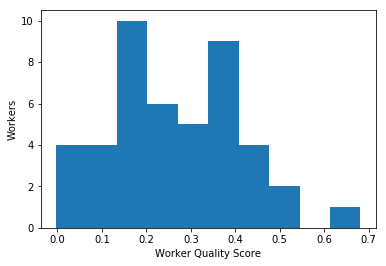

In [10]:
plt.hist(results["workers"]["wqs"])
plt.xlabel("Worker Quality Score")
plt.ylabel("Workers")